In [1]:
import radarsimpy

print("`RadarSimPy` used in this example is version: " + str(radarsimpy.__version__))

`RadarSimPy` used in this example is version: 12.6.1


# Doppler of a Turbine

## Introduction

The Doppler effect is a fascinating phenomenon that occurs when there is relative motion between a source of waves and an observer. One intriguing application of the Doppler effect is its occurrence in turbines. Turbines, commonly used in various industries such as power generation and aviation, are known for their rotational motion. As a turbine's blades rotate, they create disturbances in the surrounding fluid or air, resulting in a unique Doppler effect.

In this demonstration, we leverage the powerful ray tracing capability of [`RadarSimPy`](https://radarsimx.com/radarsimx/radarsimpy/) to simulate the intricate Doppler signatures induced by a rotating wind turbine. Additionally, we showcase the step-by-step process of plotting these Doppler signatures on a spectrogram, providing a visual representation of the frequency shifts caused by the turbine's rotation. By exploring this simulation and spectrogram plotting, we gain valuable insights into the complex nature of the Doppler effect produced by wind turbines.

## Create Radar Model

Firstly, import the required modules from `radarsimpy`. `numpy` will also be needed in this example.


In [2]:
import numpy as np
from radarsimpy import Radar, Transmitter, Receiver

### Transmitter

Setup the basic transmitter parameters through [Transmitter](https://radarsimx.github.io/radarsimpy/radar.html#radarsimpy-transmitter) module.

#### Define a Radar Transmitter

As shown in the diagram below, `f` and `t` are used to define the waveform modulation. For a linear frequency-modulated continuous waveform (FMCW), it can be specified as `f = [fstart, fend]` and `t = [tstart, tend]`. If `t` is a single number `t = t0`, which is equivalent to `t = [0, t0]`. The bandwidth of the FMCW is `abs(fstart - fend)`. `prp` is the pulse repetition period, and `prp >= (tend - tstart)`.

```
|                       prp
|                  +-----------+
|
|            +---f[1]--->  /            /            /
|                         /            /            /
|                        /            /            /
|                       /            /            /
|                      /            /            /     ...
|                     /            /            /
|                    /            /            /
|                   /            /            /
|      +---f[0]--->/            /            /
|
|                  +-------+
|                 t[0]    t[1]
```


In [3]:
tx = Transmitter(
    f=24.125e9, t=20, tx_power=20, pulses=1, channels=[dict(location=(0, 0, 0))]
)

### Receiver

Setup the receiver parameters through [Receiver](https://radarsimx.github.io/radarsimpy/radar.html#radarsimpy-receiver) module.

#### Define a Radar Receiver

- `fs` – Sampling rate (sps)
- `noise_figure` – Noise figure (dB)
- `rf_gain` – Total RF gain (dB)
- `load_resistor` – Load resistor to convert power to voltage (Ohm)
- `baseband_gain` – Total baseband gain (dB)


In [4]:
rx = Receiver(
    fs=800,
    noise_figure=4,
    rf_gain=20,
    baseband_gain=50,
    load_resistor=1000,
    channels=[dict(location=(0, 0, 0))],
)

### Radar System

Use the defined transmitter and receiver to create the radar system.


In [5]:
radar = Radar(transmitter=tx, receiver=rx)

## Target Model

Load the stl model of the target and set the `location`, `speed`, `rotation`, and `rotation_rate` of the target.

- `location`: (x, y, z) m
- `speed`: (x, y, z) m/s
- `rotation`: (yaw, pitch, roll) degree
- `rotation_rate`: (yaw, pitch, roll) degree/s

In this simulation, the target is a 3-blade turbine. The turbine is rotating along the y-axis with 50 degree/s.


In [6]:
target_1 = {
    "model": "../models/turbine.stl",
    "unit": "m",
    "location": (8, 0, 0),
    "rotation": [0, 50 * radar.time_prop["timestamp"], 0],
    "rotation_rate": (0, 0, 0),
    "speed": (0, 0, 0),
}

targets = [target_1]

_Plot the model_


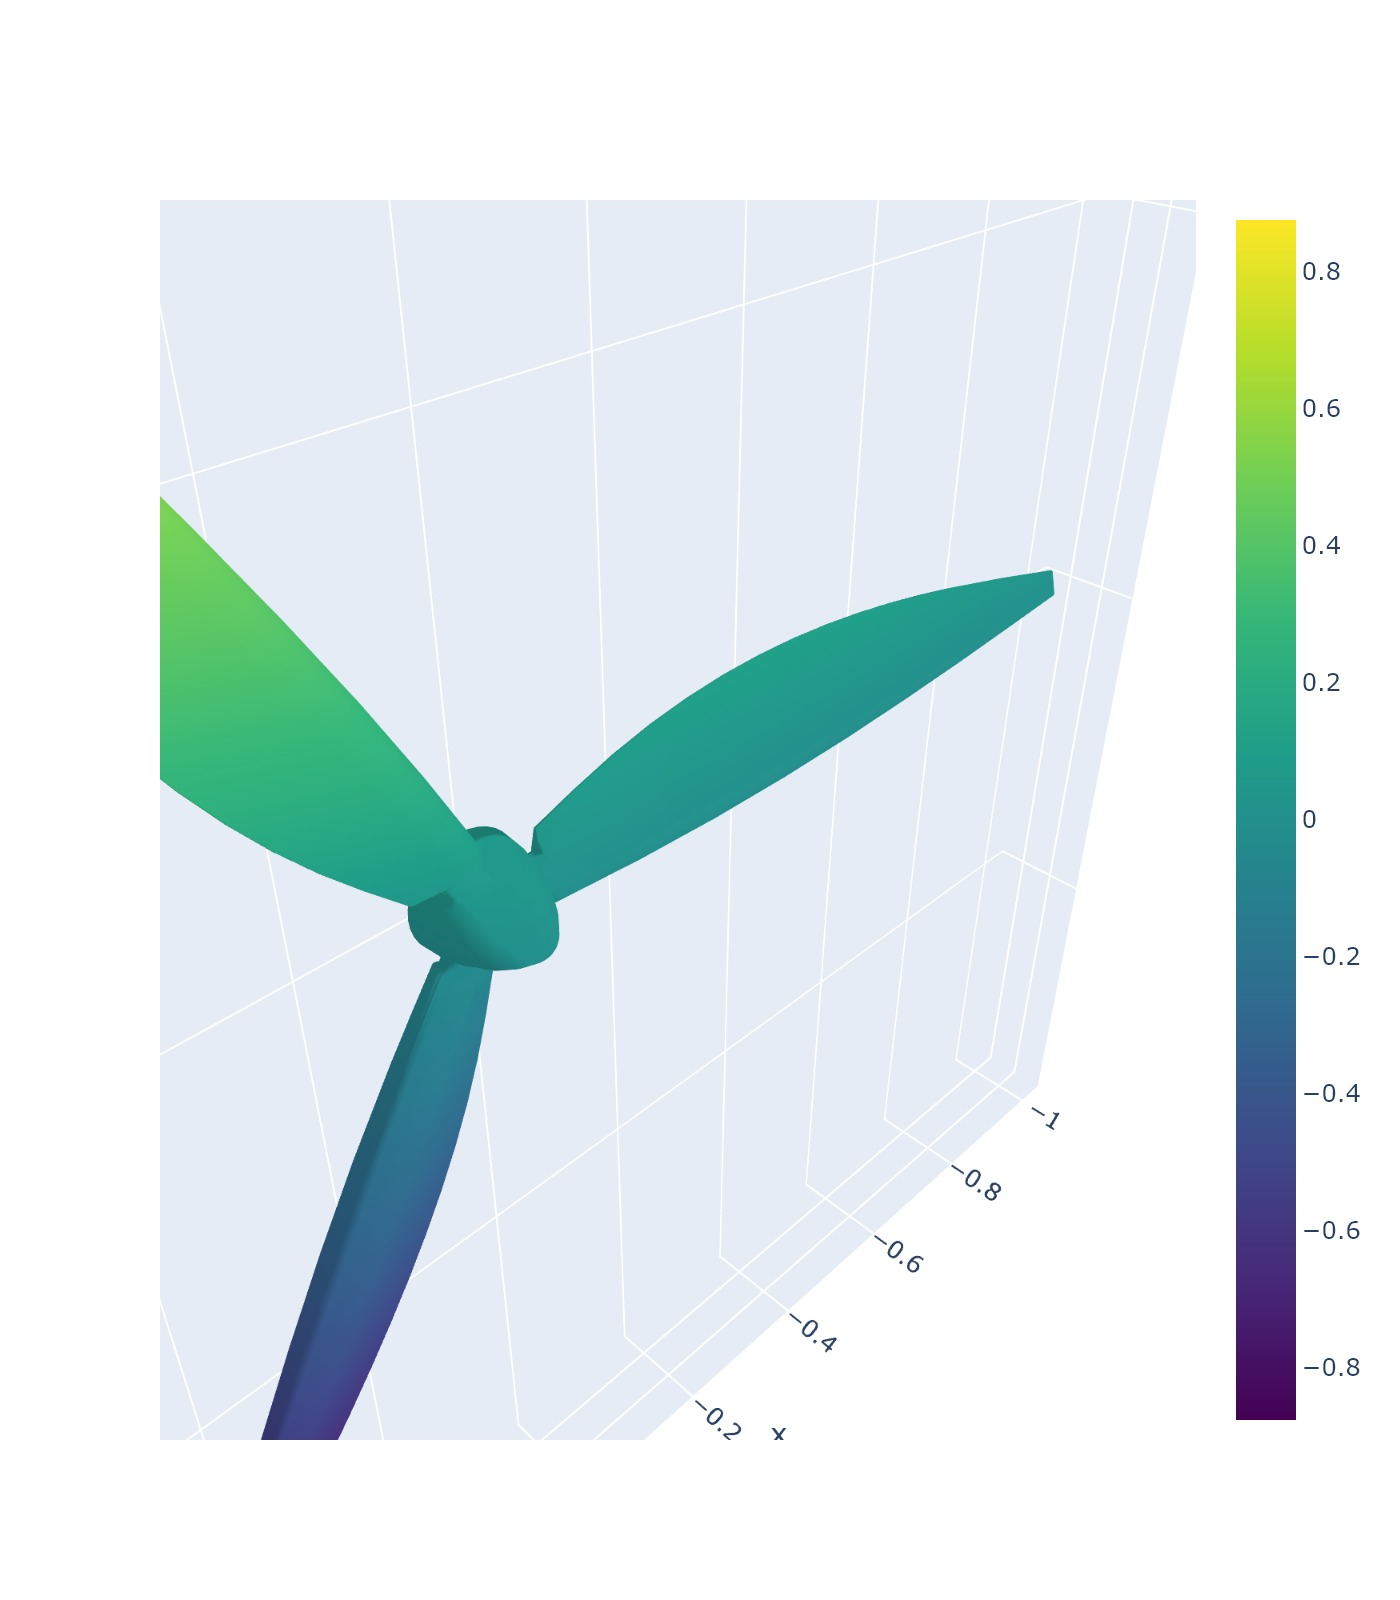

In [7]:
import pymeshlab
import plotly.graph_objs as go
from IPython.display import Image

ms = pymeshlab.MeshSet()
ms.load_new_mesh(target_1["model"])
t_mesh = ms.current_mesh()
v_matrix = np.array(t_mesh.vertex_matrix())
f_matrix = np.array(t_mesh.face_matrix())

fig = go.Figure()
fig.add_trace(
    go.Mesh3d(
        x=v_matrix[:, 0],
        y=v_matrix[:, 1],
        z=v_matrix[:, 2],
        i=f_matrix[:, 0],
        j=f_matrix[:, 1],
        k=f_matrix[:, 2],
        intensity=v_matrix[:, 2],
        colorscale="Viridis",
    )
)
fig["layout"]["scene"]["aspectmode"] = "data"
fig["layout"]["height"] = 800

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

## Radar Scene Simulation

Use the `simulator.sim_radar` module to simulate the baseband samples from the defined radar system and targets. `level='sample'` defines ray tracing for each sample point. This is the most time-consuming setup but the most accurate.

The output baseband data is a dict including the timestamp and baseband. Both of them are 3-D matrix:

`[channels, pulses, ADC samples]`


In [8]:
from radarsimpy.simulator import sim_radar
import time

tic = time.time()
data = sim_radar(radar, targets, density=2, level="sample")
baseband = data["baseband"] + data["noise"]
timestamp = data["timestamp"]
toc = time.time()

print("Exec time :" + str(toc - tic) + "s")

Exec time :130.9482765197754s


_Plot baseband samples_


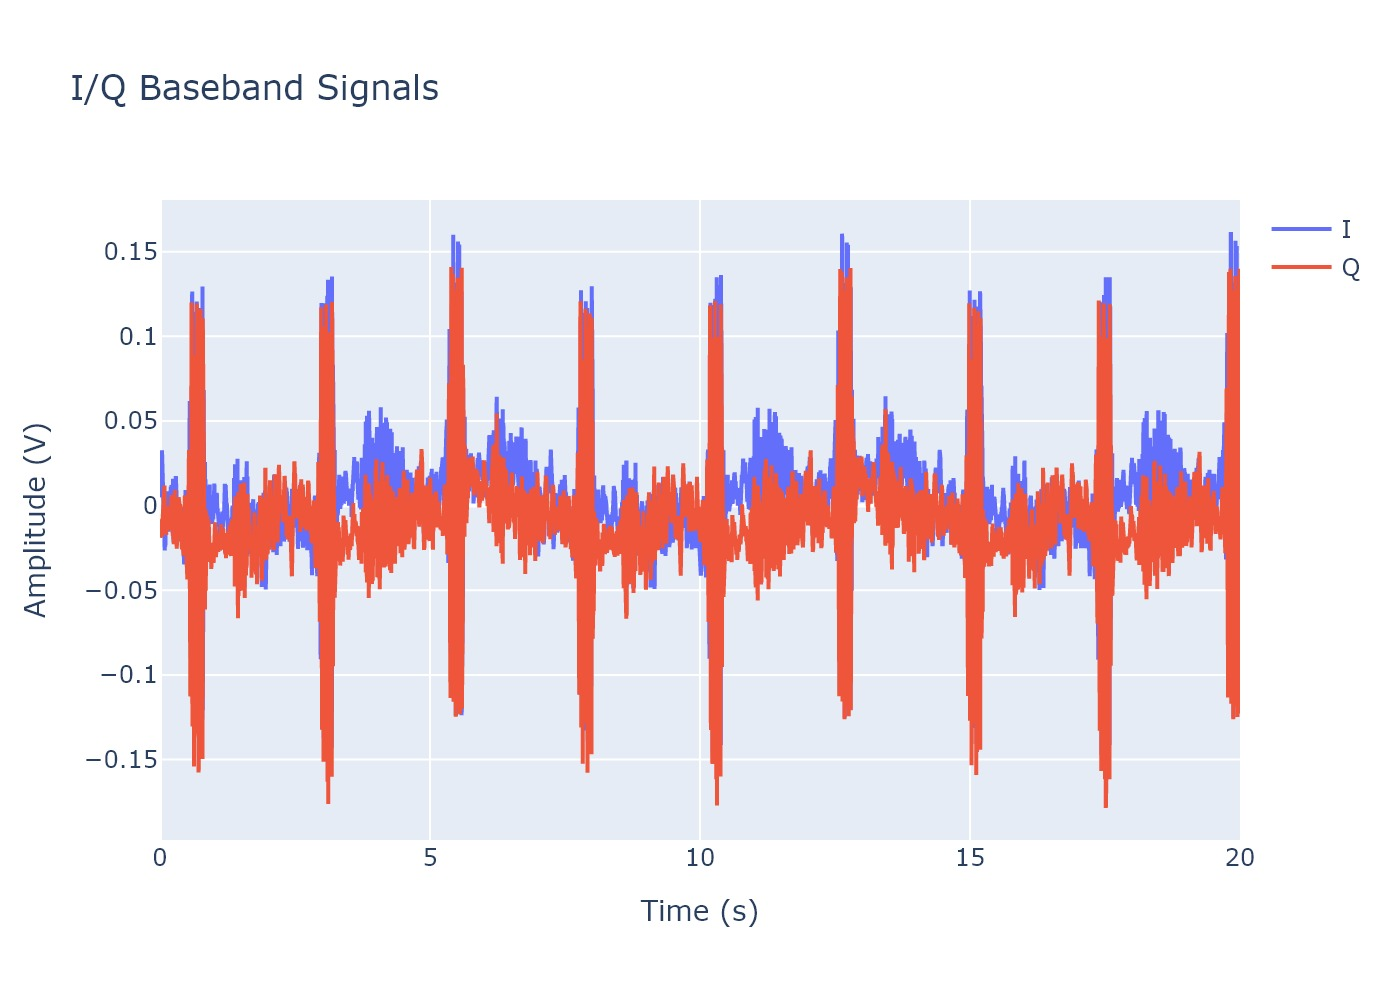

In [9]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=timestamp[0, 0, :],
        y=np.real(baseband[0, 0, :]),
        name="I",
    )
)
fig.add_trace(
    go.Scatter(
        x=timestamp[0, 0, :],
        y=np.imag(baseband[0, 0, :]),
        name="Q",
    )
)

fig.update_layout(
    title="I/Q Baseband Signals",
    yaxis=dict(title="Amplitude (V)"),
    xaxis=dict(title="Time (s)"),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

## Short-Time Fourier Transform


In [10]:
from scipy.signal import stft

spec = stft(
    baseband[0, 0, :],
    fs=radar.radar_prop["receiver"].bb_prop["fs"],
    nperseg=128,
    noverlap=120,
    nfft=512,
    return_onesided=False,
)

_Plot spectrogram_


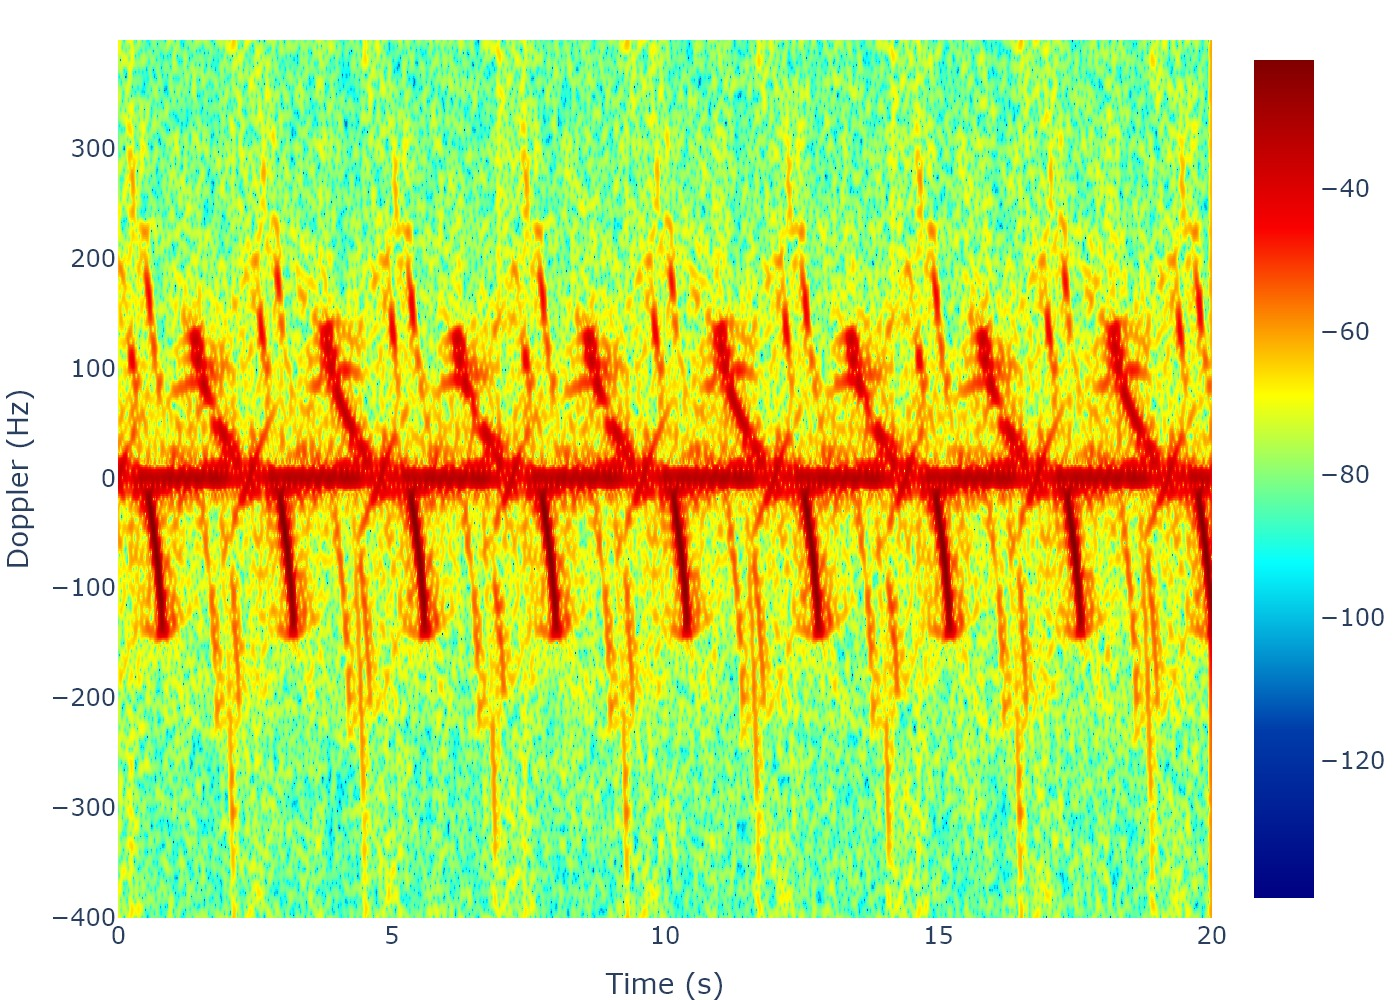

In [11]:
idx_neg = np.where(spec[0] < 0)
idx_pos = np.where(spec[0] >= 0)

dopp_ordered = spec[0][np.concatenate([idx_neg[0], idx_pos[0]])]

spec_shifted = spec[2][np.concatenate([idx_neg[0], idx_pos[0]]), :]

fig = go.Figure()

fig.add_trace(
    go.Heatmap(
        z=20 * np.log10(np.abs(spec_shifted)),
        x=spec[1],
        y=dopp_ordered,
        hoverongaps=False,
        colorscale="Jet",
    )
)

fig.update_layout(
    yaxis=dict(title="Doppler (Hz)"),
    xaxis=dict(title="Time (s)"),
    margin=dict(l=0, r=0, b=0, t=20),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))